# Regional Analyses
Building on the exploratory data analyses, this notebook analyzes and visualizes tree cover statistics at the regional level.

**Agricultural and Urban Areas Meeting Forest Cover Definition (>10%)**  
**Top 5 Admins with Trees on Farms**  
**Top 5 Admins with Urban Trees**  
**Tree Cover Distribution: Regional Comparisons**  
**Agricultural tree cover in the Sahel**

In [ ]:
import os
import rasterio as rs
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd 
import pandas as pd
import matplotlib
import glob
# from bokeh.plotting import figure, save
# from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper

## Gut Checks on Stats

In [ ]:
bel = pd.read_csv(f'Belize/stats/Belize_statistics.csv')
# check for nulls
bel.info()

In [ ]:
bel.describe()

In [ ]:
# check class count and categories
print(bel.esa_class.nunique())
bel.esa_class.value_counts()

In [ ]:
# check if any of the means are > 100%
bel[bel.tof_mean >= 100]

In [ ]:
# check if any of the means are > 100%
bel[bel.hans_mean >= 100]

In [ ]:
# make sure mean != 0 if ha > 0
bel[(bel.tof_mean == 0) & (bel.tof_ha > 0)]

In [ ]:
# in which esa classes is tof mean 0?
bel[bel.tof_mean == 0].esa_class.value_counts()

In [ ]:
# check the no data class means
bel[bel.esa_class == 'No Data (flag)']

In [ ]:
def check_stats(country):
    df = pd.read_csv(f'/Volumes/Jessicas_Life/_Processed_countries/{country}/stats/{country}_statistics.csv')
    print(f'SUMMARY FOR {country}:')
    print(df.info())
    print(' ')
    print(f'ESA LAND COVER CLASSES: {df.esa_class.nunique()}')
    print(df.esa_class.value_counts())
    print(' ')
    print(f'TOF means >100%: {len(df[df.tof_mean >= 100])}')
    print(f'Hans means >100%: {len(df[df.hans_mean >= 100])}')
    print(f'TOF NaN means: {len(df[df.tof_mean.isnull()])}')
    print(f'Hans NaN means: {len(df[df.hans_mean.isnull()])}')
    print(f'Confirm no ha if no mean: {len(df[(df.tof_mean == 0) & (df.tof_ha > 0)])}')
    print(' ')
    print('% LAND COVER THAT IS NaN')
    print(df[df.tof_mean.isnull()].esa_class.value_counts(normalize=True)*100)
    return df[:40]


In [ ]:
check_stats('Guinea Bissau')

## Create Regional Spreadsheets
Combines country stats spreadsheets into one csv for the region.

In [3]:
def create_regional_csv(list_of_countries, region, processing_extent='full'):
    
    regional_df = pd.DataFrame()
    dfs_to_concat = []
    
    for country in list_of_countries:
        try:
            country_df = pd.read_csv(f'statistics/{country}_statistics_{processing_extent}.csv')   
        except OSError:
            country_df = pd.read_csv(f'statistics/{country}_statistics_{processing_extent}_tmlonly.csv')
        
        dfs_to_concat.append(country_df)

    regional_df = pd.concat(dfs_to_concat, ignore_index=True)
    regional_df.to_csv(f'statistics/{region}.csv', index=False)
    
    return None

In [ ]:
create_regional_csv(['Belize', 'El Salvador', 'Honduras', 'Nicaragua', 'Panama', 'Guatemala', 'Costa Rica'], 
                    'central_am')

In [ ]:
create_regional_csv(['Rwanda', 'Burundi'], 'east_afr')

In [ ]:
create_regional_csv(['Ghana'], 'west_afr')

In [260]:
create_regional_csv(['Burkina Faso', 'Central African Republic','Cameroon', 'Chad', 'Ethiopia','Eritrea',
                    'Mali', 'Mauritania', 'Niger', 'Nigeria', 'Senegal', 'South Sudan', 'Sudan'], 'sahel')

## Agricultural and Urban Areas Meeting Forest Cover Definition (>10%)
The FAO defines *forest cover* as a land area of more than 0.5 ha, with a tree canopy cover of more than 10%, which is not primarily under agricultural or other specific non-forest land use (FAO 2000). The stacked barchart illustrates the tree cover in agriculture and urban areas that qualifies as forest under this definition. The light green portion indicates the total percentage of land that is not compliant (<10%) and the dark green indicates the total percentage of land that is compliant (>10%) for each country in a region. All results are for the year 2020.

In [296]:
def fao_compliant(region, filepath, lcc):
    
    df = pd.read_csv(filepath)
    
    ag_ids = [10.0, 11.0, 12.0, 20.0, 30.0, 40.0]
    urban_ids = [190.0]
    
    if lcc == 'ag':
        df = df[df.esa_id.isin(ag_ids)]
    
    if lcc == 'urban':
        df = df[df.esa_id.isin(urban_ids)]
        
    # get total ha per threshold per country
    df = df.groupby(by=['country', 'tree_cover_class']).sum().reset_index()
    df = df[['country', 'tree_cover_class', 'tof_ha']] 
    
    # remove tree cover classes <10%
    over10 = df[df.tree_cover_class != '0-9']
    over20 = df[(df.tree_cover_class != '0-9') & (df.tree_cover_class != '10-19')]
    over30 = df[(df.tree_cover_class != '0-9') & (df.tree_cover_class != '10-19') & (df.tree_cover_class != '20-29')]
    
    # calculate totals
    total = sum(df.tof_ha)
    over10_ha = sum(over10.tof_ha)
    over10_perc = sum(over10.tof_ha) / total * 100
    over20_perc = sum(over20.tof_ha) / total * 100
    over30_perc = sum(over30.tof_ha) / total * 100
    
    if lcc == 'ag':
        print(f'Total percentage of ag land in {region} that meets FAO forest cover criterion: {round((over10_perc),2)}%')
        print(f'Total percentage of ag land in {region} with >20% tree cover: {round((over20_perc),2)}%')
        print(f'Total percentage of ag land in {region} with >30% tree cover:  {round((over30_perc),2)}%')
        print(f'Total hectares of ag land in {region} that meet FAO forest cover criterion: {over10_ha} ha')
    
    if lcc == 'urban':
        print(f'Total percentage of urban land in {region} that meets FAO forest cover criterion: {round((over10_perc),2)}%')
        print(f'Total percentage of urban land in {region} with >20% tree cover: {round((over20_perc),2)}%')
        print(f'Total percentage of urban land in {region} with >30% tree cover:  {round((over30_perc),2)}%')
        print(f'Total hectares of urban land in {region} that meet FAO forest cover criterion: {over10_ha} ha')

    return None

In [ ]:
fao_compliant('Central America', '/Volumes/Jessicas_Life/regional_stats/central_am.csv', 'ag')

In [ ]:
fao_compliant('Central America', '/Volumes/Jessicas_Life/regional_stats/central_am.csv', 'urban')

In [16]:
fao_compliant('Kenya', 'Kenya_statistics.csv', 'ag')

Total percentage of ag land in Kenya that meets FAO forest cover criterion: 62.96%
Total percentage of ag land in Kenya with >20% tree cover: 47.87%
Total percentage of ag land in Kenya with >30% tree cover:  37.18%
Total hectares of ag land in Kenya that meets FAO forest cover criterion: 17849613 ha


In [17]:
fao_compliant('Kenya', 'Kenya_statistics.csv', 'urban')

Total percentage of urban land in Kenya that meets FAO forest cover criterion: 47.95%
Total percentage of urban land in Kenya with >20% tree cover: 26.75%
Total percentage of urban land in Kenya with >30% tree cover:  15.6%
Total hectares of urban land in Kenya that meets FAO forest cover criterion: 55664 ha


In [297]:
fao_compliant('Sahel', 'statistics/sahel.csv', 'ag')

Total percentage of ag land in Sahel that meets FAO forest cover criterion: 44.6%
Total percentage of ag land in Sahel with >20% tree cover: 29.14%
Total percentage of ag land in Sahel with >30% tree cover:  21.31%
Total hectares of ag land in Sahel that meet FAO forest cover criterion: 115998375 ha


In [37]:
def forest_cover_compliant_comb(region, figsize):
    
    region_df = pd.read_csv(f'statistics/{region}.csv')
    
    countries = list(set(region_df.country.values))

    x_labels, bar1, bar2 = [], [], []

    for country in countries:
        
        # filter to one country and only urban/ag land cover classes
        country_df = region_df[region_df.country == country]
        ids = [10.0, 11.0, 12.0, 20.0, 30.0, 40.0, 190.0]
        country_df = country_df[country_df.esa_id.isin(ids)]
        
        # get total tof ha per tree cover threshold
        country_df = country_df.groupby(by=['country', 'tree_cover_class']).sum().reset_index() 
        country_df = country_df[['country', 'tree_cover_class', 'tof_ha']]
        
        # calculate # ha <10% tree cover and >10% tree cover
        under10 = country_df.tof_ha[0]
        over10 = sum(country_df.tof_ha[1:])
        
        # normalize
        total = under10 + over10
        under10_norm = under10/total*100
        over10_norm = over10/total*100
        
        x_labels.append(country)
        bar1.append(over10_norm)
        bar2.append(under10_norm)
   
    # convert to array in order to add data labels
    bar1 = np.asarray(bar1)
    bar2 = np.asarray(bar2)
    
    # create the figure
    plt.figure(figsize=figsize)
    plt.bar(x_labels, bar1, color="seagreen", label='<10% cover')  
    plt.bar(x_labels, bar2, bottom=bar1, color="honeydew", label='>10% cover')    
    
    # labels
    for xpos, ypos, yval in zip(x_labels, bar1/2, bar1):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    for xpos, ypos, yval in zip(x_labels, bar1 + bar2/2, bar2):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    
    plt.xlabel(' ')
    plt.ylabel('% Land')
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(f'% Agricultural and Urban Land Meeting \n Forest Cover Definition')
    plt.legend(loc='lower right');

In [ ]:
forest_cover_compliant_comb('central_am', (8,6))

In [ ]:
def forest_cover_compliant(region, figsize):
    
    '''
    Legend for ESA land cover categories:
        10: 'Cropland, rainfed',
        11: 'Cropland, rainfed',
        12: 'Cropland, rainfed',
        20: 'Cropland, irrigated or post-flooding',
        30: 'Mosaic cropland / natural vegetation',
        40: 'Mosaic natural vegetation / cropland',
        190: 'Urban areas'
    '''
    
    region_df = pd.read_csv(f'statistics/{region}.csv')
    
    countries = list(set(region_df.country.values))

    x_labels, ag_bar1, ag_bar2, urban_bar1, urban_bar2 = [],[],[],[],[]
    
    for country in countries:
        
        # filter to one country and only urban/ag land cover classes
        country_df = region_df[region_df.country == country]
        ag_ids = [10.0, 11.0, 12.0, 20.0, 30.0, 40.0]
        urban_ids = [190.0]
        ag_df = country_df[country_df.esa_id.isin(ag_ids)].sort_values('country')
        urban_df = country_df[country_df.esa_id.isin(urban_ids)].sort_values('country')
        
        # get total tof ha per tree cover threshold
        ag_df = ag_df.groupby(by=['country', 'tree_cover_class']).sum().reset_index() 
        ag_df = ag_df[['country', 'tree_cover_class', 'tof_ha']] 
        urban_df = urban_df.groupby(by=['country', 'tree_cover_class']).sum().reset_index() 
        urban_df = urban_df[['country', 'tree_cover_class', 'tof_ha']] 
        
        # calculate # ha <10% tree cover and >10% tree cover
        ag_under10 = ag_df.tof_ha[0]
        ag_over10 = sum(ag_df.tof_ha[1:])
        urban_under10 = urban_df.tof_ha[0]
        urban_over10 = sum(urban_df.tof_ha[1:])
        
        # normalize
        ag_under10_norm = ag_under10/(ag_under10 + ag_over10)*100
        ag_over10_norm = ag_over10/(ag_under10 + ag_over10)*100
        urban_under10_norm = urban_under10/(urban_under10 + urban_over10)*100
        urban_over10_norm = urban_over10/(urban_under10 + urban_over10)*100
        
        x_labels.append(country)
        ag_bar1.append(ag_over10_norm) # >10% is on the bottom
        ag_bar2.append(ag_under10_norm) # <10% is on the top
        urban_bar1.append(urban_over10_norm) 
        urban_bar2.append(urban_under10_norm) 
   
    # convert to array in order to add data labels
    ag_bar1 = np.asarray(ag_bar1)
    ag_bar2 = np.asarray(ag_bar2)
    urban_bar1 = np.asarray(urban_bar1)
    urban_bar2 = np.asarray(urban_bar2)

    plt.figure(figsize=figsize)
    
    # create ag error bars
    ag_error = []
    lower = [-2.41, -3.64, -3.99, -3.17, -3.89, -3.93, -3.74]
    upper = [1.05, 0.41, -0.06, 0.53, 0.27, 0.03, 0.19]
    for x,y in zip(lower, upper):
        ag_error.append(y-x)
    
    # Ag plot
    plt.subplot(1,2,1)
    plt.bar(x_labels, ag_bar1, color="seagreen", label='>10% tree cover', yerr=ag_error, capsize=4)  
    plt.bar(x_labels, ag_bar2, bottom=ag_bar1, color="honeydew", label='<10% tree cover')    
    
    # labels
    for xpos, ypos, yval in zip(x_labels, ag_bar1/2, ag_bar1):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    for xpos, ypos, yval in zip(x_labels, ag_bar1 + ag_bar2/2, ag_bar2):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    
    plt.xlabel(' ')
    plt.ylabel('% Land')
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(f'% Agricultural Land Meeting \n 10% Forest Cover Criteria')
    plt.legend(loc='lower right')
    
    # create urban error bars
    urb_error = []
    lower = [-2.90, -1.91, -3.16, -1.90, -1.94, -2.40, -2.06]
    upper = [1.97, 0.64, 0.17, 0.64, 0.95, 0.92, 0.84]
    for x,y in zip(lower, upper):
        urb_error.append(y-x)

    # Urban plot
    plt.subplot(1,2,2)
    plt.bar(x_labels, urban_bar1, color="seagreen", label='>10% tree cover', yerr=urb_error, capsize=4)  
    plt.bar(x_labels, urban_bar2, bottom=urban_bar1, color="honeydew", label='<10% tree cover')    
    
    # labels
    for xpos, ypos, yval in zip(x_labels, urban_bar1/2, urban_bar1):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    for xpos, ypos, yval in zip(x_labels, urban_bar1 + urban_bar2/2, urban_bar2):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    
    
    plt.xlabel(' ')
    plt.ylabel('% Land')
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(f'% Urban Land Meeting \n 10% Forest Cover Criteria')
    plt.legend(loc='lower right')
    plt.tight_layout(); 

In [ ]:
forest_cover_compliant('central_am', (14,7))

## Top 5 Admins with Trees on Farms
This function identifies the top five administrative districts with the highest tree cover estimates (average tree cover or total ha) on agriculture land cover types.  

Outstanding items to address:
- If ha of tree cover is the metric, should be weighted

In [12]:
def top5_admins_ag(filepath):
    
    '''
    Filters dataframe to the following ESA agriculture land cover types:
    
    Cropland, rainfed
    Cropland, rainfed, herbaceous cover
    Cropland, irrigated or post-flooding
    Mosaic cropland / natural vegetation
    Mosaic natural vegetation / cropland 
    
    Calculates the total ha tree cover per admin AND the avg % tree cover per admin.
    Merges the dataframes to include % of land cover class sampled and then builds
    two separate dataframes of top 5 cities in the region with highest stats.
    
    '''
    
    df = pd.read_csv(filepath)
    
    # filter to only ag land cover classes
    ag_ids = [10.0, 11.0, 12.0, 20.0, 30.0, 40.0]
    df = df[df.esa_id.isin(ag_ids)]

    # get total (sum) ha tree cover in ag for each admin (drop ha <10% cover)
    df_ha = df.drop(df[df.tree_cover_class == '0-9'].index)
    df_ha = df.groupby(by=['country', 'admin']).sum().reset_index() 
    df_ha = df_ha[['country', 'admin', 'esa_sampled_ha', 'esa_total_ha','tof_ha']] 
    
    # add column with % of land cover class that was sampled
    df_ha['esa_perc_samp'] = round((df_ha.esa_sampled_ha / df_ha.esa_total_ha) * 100, 2)

    # now use original dataframe to get average tree cover in ag for each admin
    df_avg = df.groupby(by=['country','admin']).mean().reset_index()
    df_avg = df_avg[['country', 'admin', 'tof_mean']]
    
    # merge dataframes
    df_merged = pd.merge(df_ha, df_avg, how='inner', left_on=['country','admin'], right_on=['country','admin'])
    
    # sort and print top 5 ag areas
    top_5_ha = df_merged.sort_values(['tof_ha', 'esa_perc_samp'], ascending=(False, False))[:5]
    top_5_avg = df_merged.sort_values(['tof_mean', 'esa_perc_samp'], ascending=(False, False))[:5]
    
    print('Top 5 Admins with Trees on Farms (total hectares tree cover)')
    for i in top_5_ha.index:
        print(f'Farms in {top_5_ha.admin[i]}, {top_5_ha.country[i]} have {top_5_ha.tof_ha[i]} ' \
              f'ha of tree cover >10%. ({top_5_ha.esa_perc_samp[i]}% of farms were sampled)')
    
    print(' ')
    print('Top 5 Admins with Trees on Farms (average % tree cover)')
    for i in top_5_avg.index:
        print(f'Farms in {top_5_avg.admin[i]}, {top_5_avg.country[i]} have {round(top_5_avg.tof_mean[i], 0)}% ' \
              f'average tree cover. ({top_5_avg.esa_perc_samp[i]}% of farms were sampled)')

    return df_merged

In [14]:
central_am = top5_admins_ag('statistics/central_america_full.csv')

Top 5 Admins with Trees on Farms (total hectares tree cover)
Farms in Petén, Guatemala have 1909511 ha of tree cover >10%. (99.2% of farms were sampled)
Farms in Atlántico Sur, Nicaragua have 1240209 ha of tree cover >10%. (98.22% of farms were sampled)
Farms in Olancho, Honduras have 833001 ha of tree cover >10%. (98.89% of farms were sampled)
Farms in Veraguas, Panama have 587195 ha of tree cover >10%. (99.74% of farms were sampled)
Farms in Atlántico Norte, Nicaragua have 570732 ha of tree cover >10%. (98.44% of farms were sampled)
 
Top 5 Admins with Trees on Farms (average % tree cover)
Farms in Kuna Yala, Panama have 83.0% average tree cover. (63.71% of farms were sampled)
Farms in Emberá, Panama have 75.0% average tree cover. (76.82% of farms were sampled)
Farms in Chimaltenango, Guatemala have 52.0% average tree cover. (96.39% of farms were sampled)
Farms in Quezaltenango, Guatemala have 50.0% average tree cover. (99.05% of farms were sampled)
Farms in El Progreso, Guatemala ha

In [16]:
sahel = top5_admins_ag('statistics/sahel.csv')

Top 5 Admins with Trees on Farms (total hectares tree cover)
Farms in Oromia, Ethiopia have 13721530 ha of tree cover >10%. (99.81% of farms were sampled)
Farms in Amhara, Ethiopia have 9411048 ha of tree cover >10%. (99.86% of farms were sampled)
Farms in Koulikoro, Mali have 8341297 ha of tree cover >10%. (99.72% of farms were sampled)
Farms in West Kurdufan, Sudan have 7275797 ha of tree cover >10%. (99.92% of farms were sampled)
Farms in Borno, Nigeria have 6408848 ha of tree cover >10%. (94.81% of farms were sampled)
 
Top 5 Admins with Trees on Farms (average % tree cover)
Farms in Sud, Cameroon have 77.0% average tree cover. (88.79% of farms were sampled)
Farms in Sud-Ouest, Cameroon have 76.0% average tree cover. (98.69% of farms were sampled)
Farms in Mbomou, Central African Republic have 71.0% average tree cover. (95.6% of farms were sampled)
Farms in Littoral, Cameroon have 70.0% average tree cover. (94.73% of farms were sampled)
Farms in Ekiti, Nigeria have 70.0% average tr

## Top 5 Admins with Urban Trees
This function identifies the top five administrative districts with the highest tree cover estimates (average tree cover or total ha) on urban land cover types.  

Outstanding items to address:
- If ha of tree cover is the metric, should be weighted

In [ ]:
def top5_admins_urb(region):
    
    '''
    Filters dataframe to the ESA urban land cover class. 
    
    Calculates the total ha tree cover per admin or the comb avg  % tree cover per admin,
    then sorts values in descending order to get top 5 admins.
    
    '''
    
    df = pd.read_csv(f'/Volumes/Jessicas_Life/regional_stats/{region}.csv')
    
    # filter to only urban land cover class
    df = df[df.esa_id == 190.0]
    
    # get total (sum) ha tree cover in urban class for each admin
    df_ha = df.groupby(by=['country', 'admin']).sum().reset_index() 
    df_ha = df_ha[['country', 'admin', 'esa_sampled_ha', 'esa_total_ha','tof_ha']] 
    
    # add column with % of land cover class that was sampled
    df_ha['esa_perc_samp'] = round((df_ha.esa_sampled_ha / df_ha.esa_total_ha) * 100, 2)

    # now use original dataframe to get average tree cover in urban class for each admin
    df_avg = df.groupby(by=['country','admin']).mean().reset_index()
    df_avg = df_avg[['country', 'admin', 'tof_mean']]
    
    # merge dataframes
    df_merged = pd.merge(df_ha, df_avg, how='inner', left_on=['country','admin'], right_on=['country','admin'])
    
    # sort and print top 5 urban areas
    top_5_ha = df_merged.sort_values(['tof_ha', 'esa_perc_samp'], ascending=(False, False))[:5]
    top_5_ha = top_5_ha.reset_index().drop('index', 1)
    top_5_avg = df_merged.sort_values(['tof_mean', 'esa_perc_samp'], ascending=(False, False))[:5]
    top_5_avg = top_5_avg.reset_index().drop('index', 1)

    
    print('Top 5 Cities with Trees (total hectares tree cover)')
    for i in top_5_ha.index:
        print(f'{top_5_ha.esa_perc_samp[i]}% of urban areas were sampled in {top_5_ha.admin[i]}, ' \
              f'{top_5_ha.country[i]} with {top_5_ha.tof_ha[i]} ha of tree cover >0%.')
    
    print(' ')
    print('Top 5 Cities with Trees (average % tree cover)')
    for i in top_5_avg.index:
        print(f'{top_5_avg.esa_perc_samp[i]}% of urban areas were sampled in {top_5_avg.admin[i]}, ' \
              f'{top_5_avg.country[i]} with {round(top_5_avg.tof_mean[i], 0)}% average tree cover.')
        
    # display top 5 ha
#     num1 = rs.open(f'{top_5_ha.country[0]}/resampled_rasters/tof/{top_5_ha.admin[0]}.tif').read(1)
#     num2 = rs.open(f'{top_5_ha.country[1]}/resampled_rasters/tof/{top_5_ha.admin[1]}.tif').read(1)
    
#     plt.figure(figsize=(30,20))

#     plt.subplot(1,2,1)
#     plt.imshow(num1, cmap='Greens', vmin=0, vmax=100)
#     plt.title(f'#1: {top_5_ha.admin[0]}, {top_5_ha.country[0]} (ha tree cover)')

#     plt.subplot(1,2,2)
#     plt.imshow(num2, cmap='Greens', vmin=0, vmax=100)
#     plt.title(f'#2: {top_5_ha.admin[1]}, {top_5_ha.country[1]} (ha tree cover)')

    # figure out where in that admin has the highest tree cover by lat/lon coordinates?
    # long term could scale down to admin 2 level in these areas?

    return None

In [ ]:
top5_admins_urb('central_am')

In [5]:
# new version for multi scale output

def urban_cover_admin(filepath):
    
    '''
    Filters dataframe to the following ESA urban land cover types:
    
    Urban
    
    Calculates the total ha tree cover per admin AND the avg % tree cover per admin.
    Merges the dataframes to include % of land cover class sampled and then builds
    two separate dataframes of top 5 cities in the region with highest stats.
    
    '''
    
    df = pd.read_csv(filepath)
    
    # filter to only urban land cover
    df = df[df.esa_id == 190]

    # get total (sum) ha tree cover in ag for each admin (drop ha <10% cover)
    df_ha = df.drop(df[df.tree_cover_class == '0-9'].index)
    df_ha = df.groupby(by=['country', 'admin']).sum().reset_index() 
    df_ha = df_ha[['country', 'admin', 'esa_sampled_ha', 'esa_total_ha','tof_ha']] 
    
    # add column with % of land cover class that was sampled
    df_ha['esa_perc_samp'] = round((df_ha.esa_sampled_ha / df_ha.esa_total_ha) * 100, 2)

    # now use original dataframe to get average tree cover in ag for each admin
    df_avg = df.groupby(by=['country','admin']).mean().reset_index()
    df_avg = df_avg[['country', 'admin', 'tof_mean']]
    
    # merge dataframes
    df_merged = pd.merge(df_ha, df_avg, how='inner', left_on=['country','admin'], right_on=['country','admin'])
    
    # sort and print top 5 ag areas
    top_5_ha = df_merged.sort_values(['tof_ha', 'esa_perc_samp'], ascending=(False, False))[:5]
    top_5_avg = df_merged.sort_values(['tof_mean', 'esa_perc_samp'], ascending=(False, False))[:5]
    
    print('Top 5 Admins with Urban Tree Cover (total hectares tree cover)')
    for i in top_5_ha.index:
        print(f'Urban areas in {top_5_ha.admin[i]}, {top_5_ha.country[i]} have {top_5_ha.tof_ha[i]} ' \
              f'ha of tree cover >10%. ({top_5_ha.esa_perc_samp[i]}% of urban areas were sampled)')
    
    print(' ')
    print('Top 5 Admins with Urban Tree Cover (average % tree cover)')
    for i in top_5_avg.index:
        print(f'Urban Areas in {top_5_avg.admin[i]}, {top_5_avg.country[i]} have {round(top_5_avg.tof_mean[i], 0)}% ' \
              f'average tree cover. ({top_5_avg.esa_perc_samp[i]}% of urban areas were sampled)')
    
    return None

In [8]:
urban_cover_admin('statistics/El Salvador_statistics_full.csv')

Top 5 Admins with Urban Tree Cover (total hectares tree cover)
Urban areas in San Salvador, El Salvador have 14397 ha of tree cover >10%. (99.84% of urban areas were sampled)
Urban areas in La Libertad, El Salvador have 6499 ha of tree cover >10%. (98.13% of urban areas were sampled)
Urban areas in Santa Ana, El Salvador have 3735 ha of tree cover >10%. (99.45% of urban areas were sampled)
Urban areas in San Miguel, El Salvador have 2407 ha of tree cover >10%. (96.93% of urban areas were sampled)
Urban areas in Sonsonate, El Salvador have 2406 ha of tree cover >10%. (95.25% of urban areas were sampled)
 
Top 5 Admins with Urban Tree Cover (average % tree cover)
Urban Areas in Usulután, El Salvador have 38.0% average tree cover. (100.0% of urban areas were sampled)
Urban Areas in Morazán, El Salvador have 38.0% average tree cover. (100.0% of urban areas were sampled)
Urban Areas in La Libertad, El Salvador have 34.0% average tree cover. (98.13% of urban areas were sampled)
Urban Areas i

## Tree Cover Distribution: Regional Comparisons
This grouped barchart compares tree cover distribution in 10% canopy cover thresholds across four regions: Central America, East Africa, West Africa, Sahel). (In the future could consider a facet grid that illustrates the distribution in a barchart per country)

In [9]:
def tree_cover_distribution(figsize):
    
    # later will be updated to compare across 4 regions
    central_am = pd.read_csv('statistics/central_america_full.csv')
    #east_afr = pd.read_csv('regional_stats/east_afr.csv')
    west_afr = pd.read_csv('statistics/west_africa_full.csv')
    sahel = pd.read_csv('statistics/sahel.csv')

    central_am = central_am.groupby(by=['tree_cover_class']).sum().reset_index() 
    central_am = central_am[['tree_cover_class', 'tof_ha']]

    west_afr = west_afr.groupby(by=['tree_cover_class']).sum().reset_index() 
    west_afr = west_afr[['tree_cover_class', 'tof_ha']]
    
    sahel = sahel.groupby(by=['tree_cover_class']).sum().reset_index() 
    sahel = sahel[['tree_cover_class', 'tof_ha']]

    labels = list(central_am.tree_cover_class)
    x = np.arange(len(labels))  # the label locations
    width = 0.35  

    plt.figure(figsize=figsize)
    plt.bar(x - width/3, central_am.tof_ha, width, label='Central America')
    plt.bar(x + width/3, west_afr.tof_ha, width, label='West Africa')
    plt.bar(x + width/3, sahel.tof_ha, width, label='Sahel')

    plt.title('Tree Cover Distribution by Region')
    plt.xlabel('Thresholds (%)')
    plt.ylabel('Total Ha')
    plt.xticks(x, labels=labels)
    plt.ticklabel_format(style='plain', axis='y')
    plt.grid(axis='y', linestyle='-', linewidth=.2)
    plt.legend();
    
    return None

## Sahel Map: Average agricultural tree cover per admin 

In [3]:
### create sahel admin 0 shapefile
shapefiles = glob.glob('visualize/sahel_admin0/*.shp')
admin0 = gpd.GeoDataFrame(pd.concat([gpd.read_file(shp) for shp in shapefiles], ignore_index=True), 
                          crs=gpd.read_file(shapefiles[0]).crs)

In [4]:
# create sahel admin 1 shapefile
countries = ['Burkina Faso', 'Cameroon', 'Chad', 'Ethiopia', 'Mali', 'Mauritania', 'Niger', 'Senegal']
countries2 = ['Central African Republic', 'Eritrea', 'Nigeria', 'South Sudan', 'Sudan']
shapefiles, shapefiles2 = [], []

In [5]:
for country in countries:
    path = f'visualize/{country}_adminboundaries.geojson'
    shapefiles.append(path)
    
for country in countries2:
    path = f'visualize/{country}_adminboundaries.geojson'
    shapefiles2.append(path)

In [6]:
gdf = gpd.GeoDataFrame(pd.concat([gpd.read_file(shp) for shp in shapefiles], ignore_index=True), 
                       crs=gpd.read_file(shapefiles[0]).crs)

In [7]:
gdf2 = gpd.GeoDataFrame(pd.concat([gpd.read_file(shp) for shp in shapefiles2], ignore_index=True), 
                       crs=gpd.read_file(shapefiles2[0]).crs)

In [8]:
# combine gdf and gdf2 by updating gdf2
# drop ISO_1 column
# change ID_0 to GID_0 and ID_1 to GID_1
# change COUNTRY to NAME_0
gdf2.drop(columns='ISO_1', inplace=True)
gdf2.rename(columns={"ID_0": "GID_0", "COUNTRY": "NAME_0", "ID_1": "GID_1"}, inplace=True)

In [9]:
final_gdf = pd.concat([gdf, gdf2], ignore_index=True)
final_gdf.shape

(189, 11)

In [10]:
# filter stats to only show tof_mean per land cover, per admin

#     Legend for ESA land cover categories:
#         10: 'Cropland, rainfed',
#         11: 'Cropland, rainfed',
#         12: 'Cropland, rainfed',
#         20: 'Cropland, irrigated or post-flooding',
#         30: 'Mosaic cropland / natural vegetation',
#         40: 'Mosaic natural vegetation / cropland',

ag_ids = [10.0, 11.0, 12.0, 20.0, 30.0, 40.0]

# when turning this into a function, takes input of which esa_class to visualize
sahel_stats = pd.read_csv('statistics/sahel.csv')
sahel_stats = sahel_stats[['country', 'admin', 'esa_id', 'esa_class', 'tof_mean']]
sahel_stats = sahel_stats[sahel_stats.esa_id.isin(ag_ids)]
sahel_stats = sahel_stats.groupby(by=['country','admin','esa_class']).mean().reset_index() #remove?

# now need to combine the ag classes and get one mean for the admin
sahel_stats.drop(columns='esa_id', inplace=True)
sahel_stats = sahel_stats.groupby(by=['country','admin']).mean().reset_index()

# merge shapefile with tree cover data
comb = final_gdf.merge(sahel_stats, left_on='NAME_1', right_on='admin')

In [67]:
bin_labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
comb['binned'] = pd.cut(comb['tof_mean'],
                        bins=10,
                        labels=bin_labels)

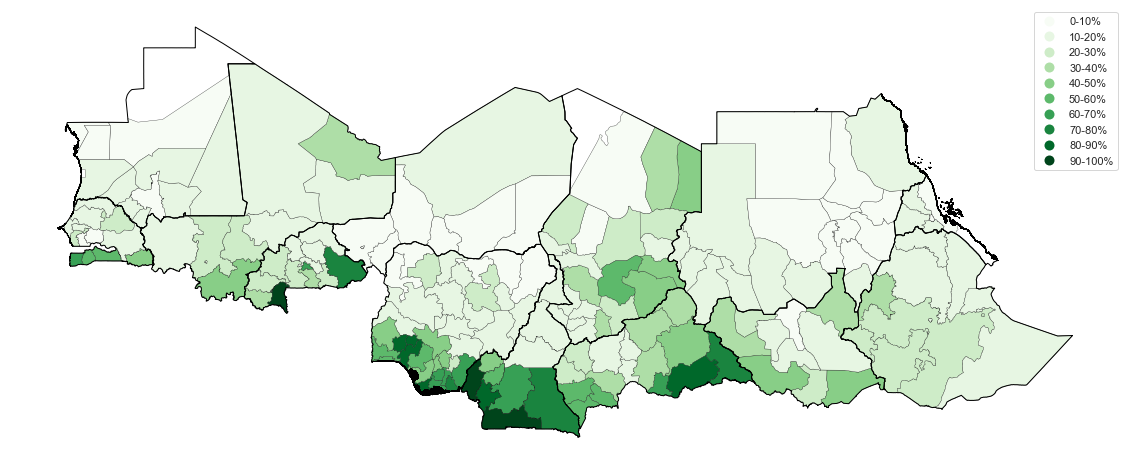

In [77]:
ax = comb.plot(column='binned', 
         cmap='Greens', 
         edgecolor='k',
         figsize=(20,20),
         linewidth=.3,
         legend=True)
#          vmin=0, 
#          vmax=100,
#          legend=True
#          #legend_kwds={'shrink': 0.3})

admin0.plot(ax=ax,
            color='none',
            edgecolor='black',
            figsize=(20,20),
            linewidth=1.0)

#plt.title(f'Mean % tree cover on farms (per admin 1 boundary)')
plt.axis('off');

# ax = moz_admin.plot(color='none', edgecolor='black', linewidths=1.5)
# moz_admin_district.plot(ax=ax, color='none', edgecolor='grey', linewidths=0.5)

In [77]:
#  input of which esa_class to visualize

def mean_tree_cover_farms(country):
    
    shapefile = gpd.read_file(f'visualize/{country}_adminboundaries.geojson')
    stats = pd.read_csv(f'statistics/{country}_statistics_full_tmlonly.csv')

    ag_ids = [10.0, 11.0, 12.0, 20.0, 30.0, 40.0]

    stats = stats[['country', 'admin', 'esa_id', 'esa_class', 'tof_mean']]
    stats = stats[stats.esa_id.isin(ag_ids)]
    stats = stats.groupby(by=['admin','esa_class']).mean().reset_index()
    stats.drop(columns='esa_id', inplace=True)
    stats = stats.groupby(by=['admin']).mean().reset_index()
    new = shapefile.merge(sahel_stats, left_on='NAME_1', right_on='admin')

    new.plot(column='tof_mean', 
             cmap='Greens', 
             edgecolor='k',
             linewidth=.3,
             legend=True,
             legend_kwds={'shrink': 0.3},
             figsize=(10,10),
             vmin=0,
             vmax=100)
    plt.title(f'Mean tree cover on Farms in {country}')
    plt.axis('off');
    return None

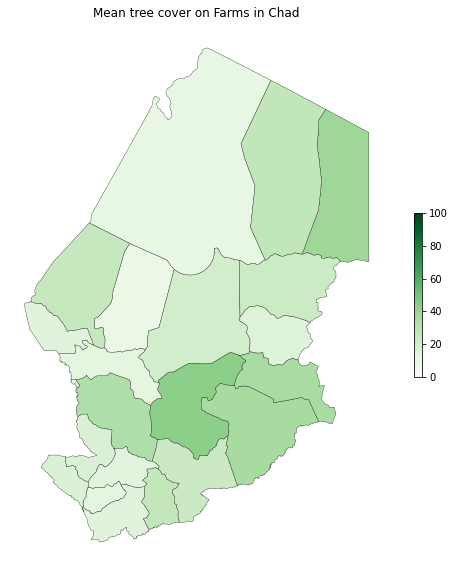

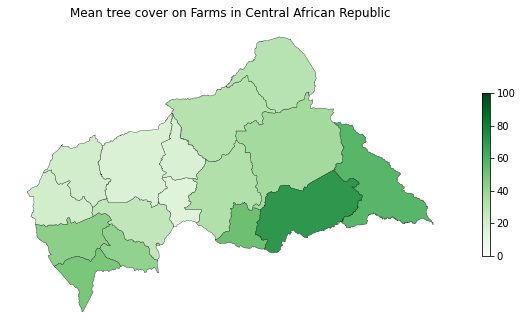

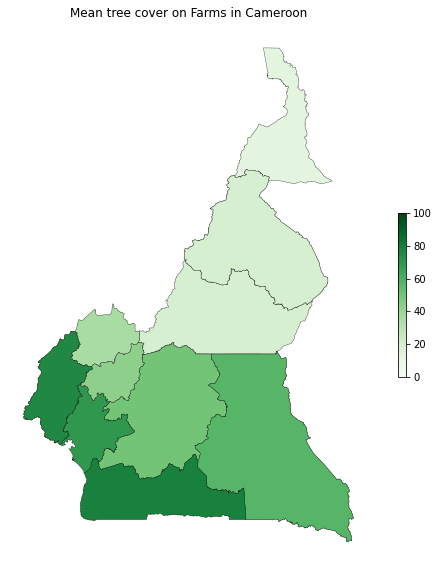

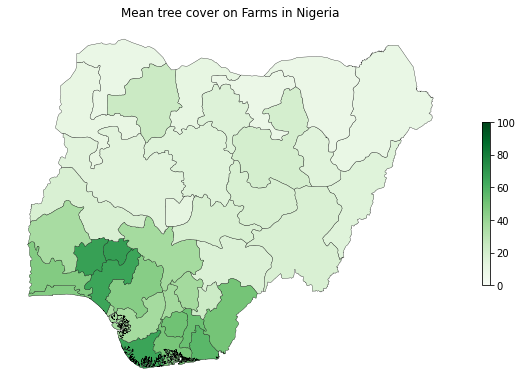

In [78]:
mean_tree_cover_farms('Chad')
mean_tree_cover_farms('Central African Republic')
mean_tree_cover_farms('Cameroon')
mean_tree_cover_farms('Nigeria')

## Open vs Closed Canopy Forests %

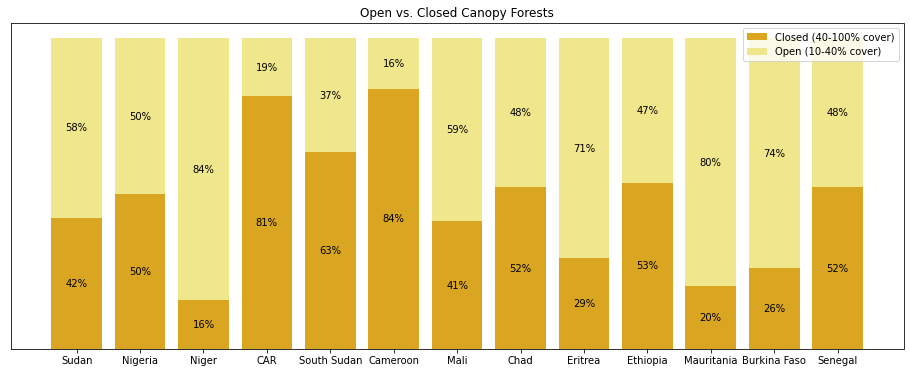

In [16]:
region_df = pd.read_csv('statistics/sahel.csv')
    
countries = list(set(region_df.country.values))

x_labels, bar1, bar2 = [],[],[]

for country in countries: 
    
    # filter to one country and only urban/ag land cover classes
    country_df = region_df[region_df.country == country]

    # get total tof ha per tree cover threshold
    country_df = country_df.groupby(by=['country', 'tree_cover_class']).sum().reset_index() 
    country_df = country_df[['country', 'tree_cover_class', 'tof_ha']]
    
    # calculate # ha <10% tree cover and >10% tree cover
    tc_closed_open = sum(country_df.tof_ha[1:]) # >10%
    tc_open = sum(country_df.tof_ha[1:4]) # 10-40%
    tc_closed = sum(country_df.tof_ha[4:]) #40-100%
    
    # create percentage labels
    total = tc_closed + tc_open
    tc_open_perc = tc_open/total*100
    tc_closed_perc = tc_closed/total*100

    x_labels.append(country)
    bar1.append(tc_closed_perc)
    bar2.append(tc_open_perc)
    
# convert to array in order to add data labels
bar1 = np.asarray(bar1)
bar2 = np.asarray(bar2)

# using list comprehension + map() + lambda
# Replace substring in list of strings
x_labels_new = list(map(lambda x: str.replace(x, 'Central African Republic','CAR'), x_labels))

# create the figure - closed on bottom
plt.figure(figsize=(16,6))
plt.bar(x_labels_new, bar1, color="goldenrod", label='Closed (40-100% cover)')  
plt.bar(x_labels_new, bar2, bottom=bar1, color="khaki", label='Open (10-40% cover)')    

# labels
for xpos, ypos, yval in zip(x_labels_new, bar1/2, bar1):
    plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
for xpos, ypos, yval in zip(x_labels_new, bar1 + bar2/2, bar2):
    plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")

plt.xlabel(' ')
#plt.ylabel('tree cover (ha)')
plt.yticks([])
plt.ticklabel_format(style='plain', axis='y')
plt.title(f'Open vs. Closed Canopy Forests')
plt.legend(loc='upper right');

In [18]:
## Create a table that shows total hectares of trees on farms per country

df = pd.read_csv('statistics/sahel.csv')
    
# filter to only ag land cover classes
ag_ids = [10.0, 11.0, 12.0, 20.0, 30.0, 40.0]
df = df[df.esa_id.isin(ag_ids)]

# get total (sum) ha tree cover in ag for country (drop ha <10% cover)
df_ha = df.drop(df[df.tree_cover_class == '0-9'].index)
df_ha = df.groupby(by=['country']).sum().reset_index() 
df_ha = df_ha[['country', 'tof_ha']] 
df_ha['tof_ha_rnd'] = round(df_ha.tof_ha / 1000000, 2)

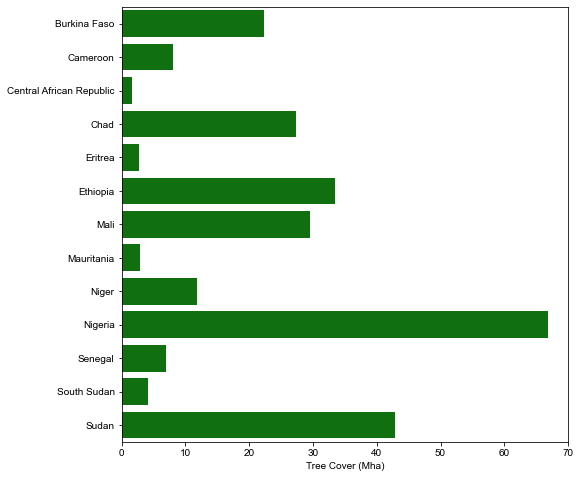

In [19]:
# create a horizontal bar chart w/ data labels
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x='tof_ha_rnd', y='country', data=df_ha, color="green")
ax.set(xlim=(0, 70), 
       ylabel='',
       xlabel="Tree Cover (Mha)",
       title="")
sns.set(font_scale=1, style='whitegrid');

In [20]:
df = pd.read_csv('statistics/sahel.csv')
    
# filter to only ag land cover classes
grass_ids = [130]
df = df[df.esa_id.isin(grass_ids)]

# get total (sum) ha tree cover in ag for country (drop ha <10% cover)
df_ha = df.drop(df[df.tree_cover_class == '0-9'].index)
df_ha = df.groupby(by=['country']).sum().reset_index() 
df_ha = df_ha[['country', 'tof_ha']] 
df_ha['tof_ha_rnd'] = round(df_ha.tof_ha / 1000000, 2)

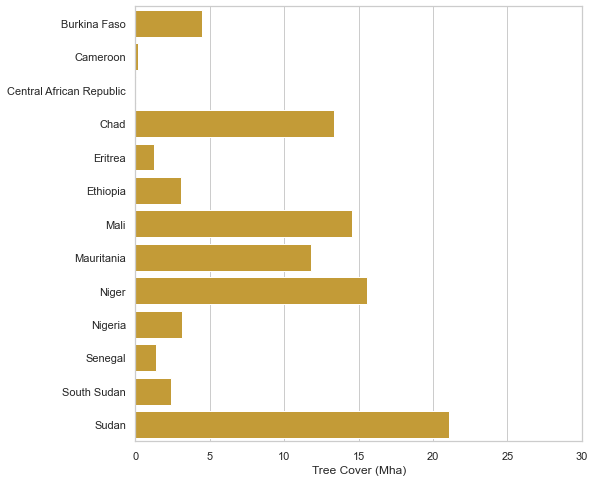

In [88]:
# create a horizontal bar chart w/ data labels
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x='tof_ha_rnd', y='country', data=df_ha, color="goldenrod")
ax.set(xlim=(0, 30), 
       ylabel='',
       xlabel="Tree Cover (Mha)",
       title="")
sns.set(font_scale=1, style='whitegrid');